In [6]:
# Import linear algebra and data manipulation libraries
import numpy as np
import pandas as pd

# Import standard visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import machine learning libraries
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost

# Import tools for model evaluation and hyperparameter search
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Load the dataset
df = pd.read_csv('/content/bank.csv')
print (df.head(5))

   age         job  marital  education default  balance housing loan  contact  \
0   59      admin.  married  secondary      no     2343     yes   no  unknown   
1   56      admin.  married  secondary      no       45      no   no  unknown   
2   41  technician  married  secondary      no     1270     yes   no  unknown   
3   55    services  married  secondary      no     2476     yes   no  unknown   
4   54      admin.  married   tertiary      no      184      no   no  unknown   

   day month  duration  campaign  pdays  previous poutcome deposit  
0    5   may      1042         1     -1         0  unknown     yes  
1    5   may      1467         1     -1         0  unknown     yes  
2    5   may      1389         1     -1         0  unknown     yes  
3    5   may       579         1     -1         0  unknown     yes  
4    5   may       673         2     -1         0  unknown     yes  


# Data Exploration

In [7]:
# Number of rows in the dataset
print("Bank marketing dataset consists of {rows} rows.".format(rows=len(df)))

# Find percentage of missing values for each column
missing_values = df.isnull().mean() * 100
total_missing_percentage = missing_values.sum()

print("Total percentage of missing values in the dataset: {:.2f}%".format(total_missing_percentage))


Bank marketing dataset consists of 11162 rows.
Total percentage of missing values in the dataset: 0.00%


#Categorical columns exploration

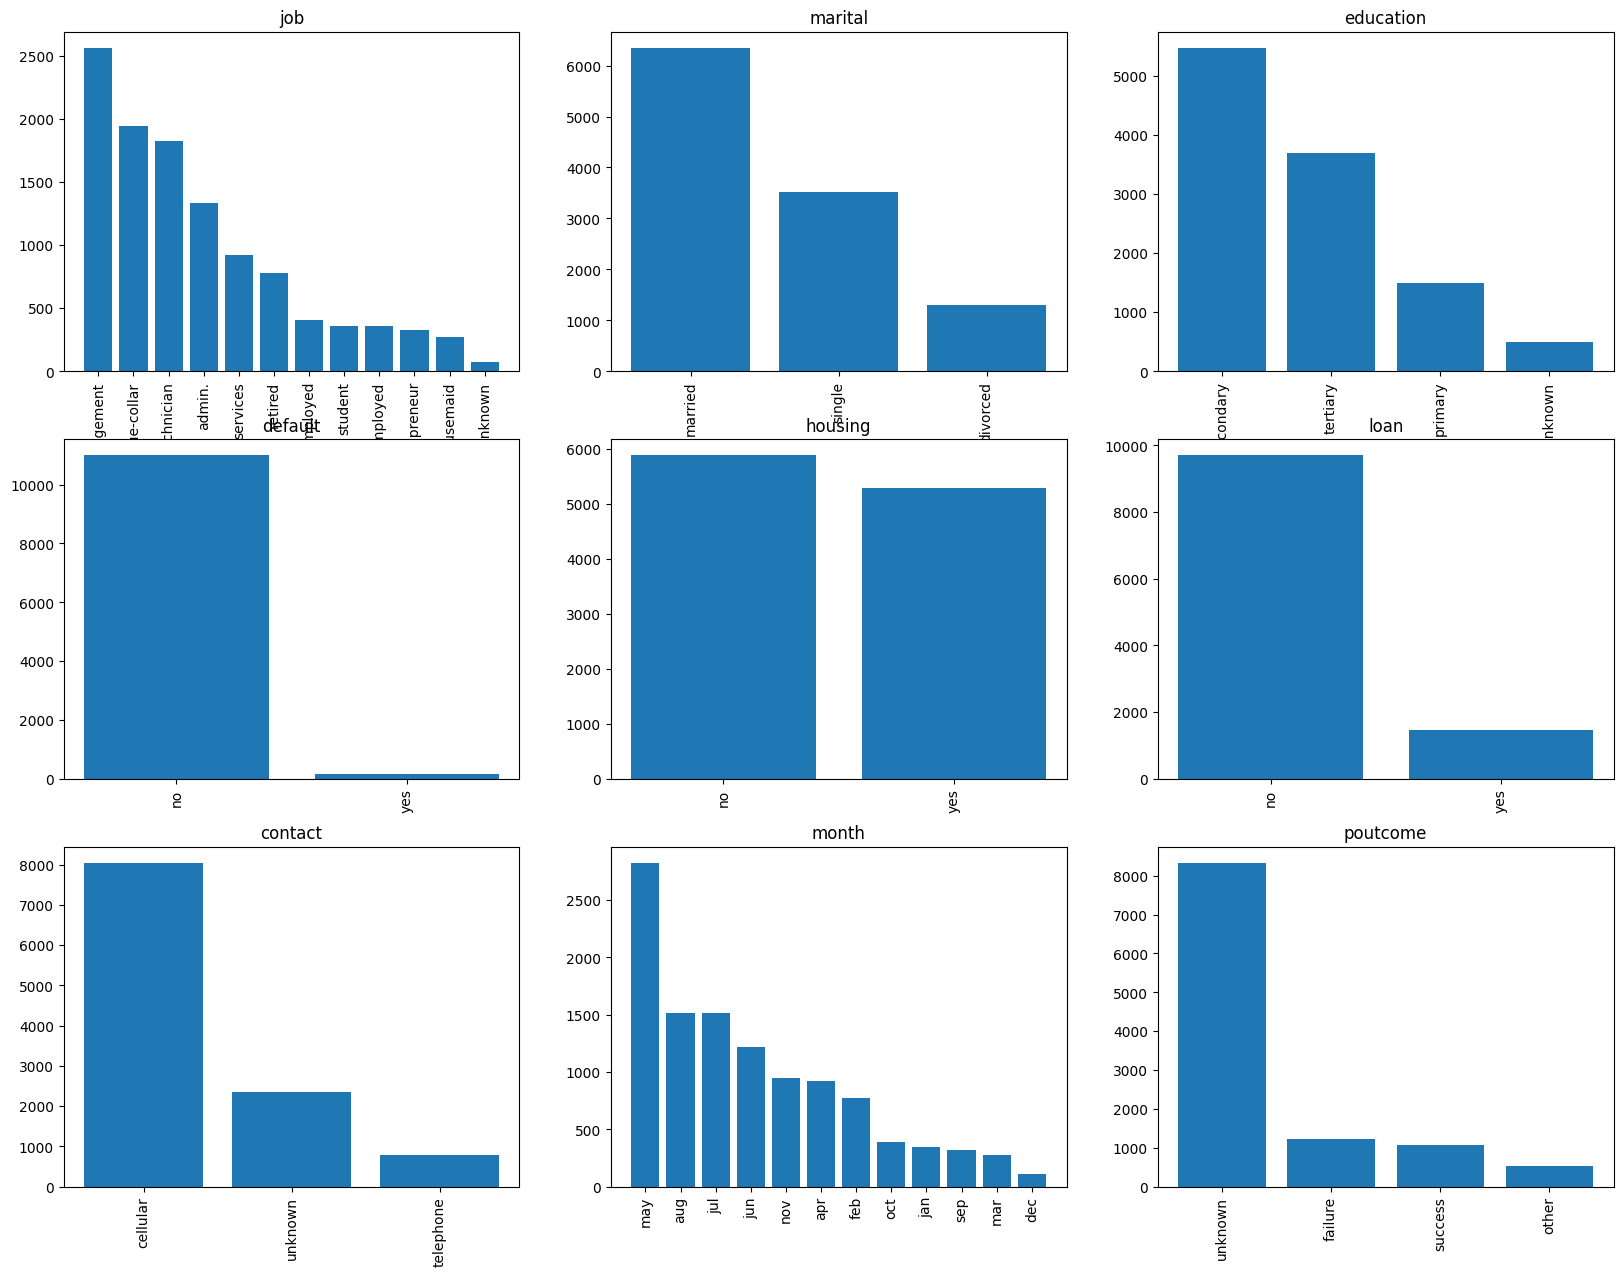

In [8]:
# List of categorical columns to be plotted
cat_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

fig, axs = plt.subplots(3, 3, figsize=(20, 15))

for ax, cat_column in zip(axs.flatten(), cat_columns):
    value_counts = df[cat_column].value_counts()

# Create a bar chart for the current category column
    ax.bar(value_counts.index, value_counts.values)
    ax.set_title(cat_column)
    ax.tick_params(axis='x', rotation=90)

# Display the plot
plt.show()


#Numerical columns exploration

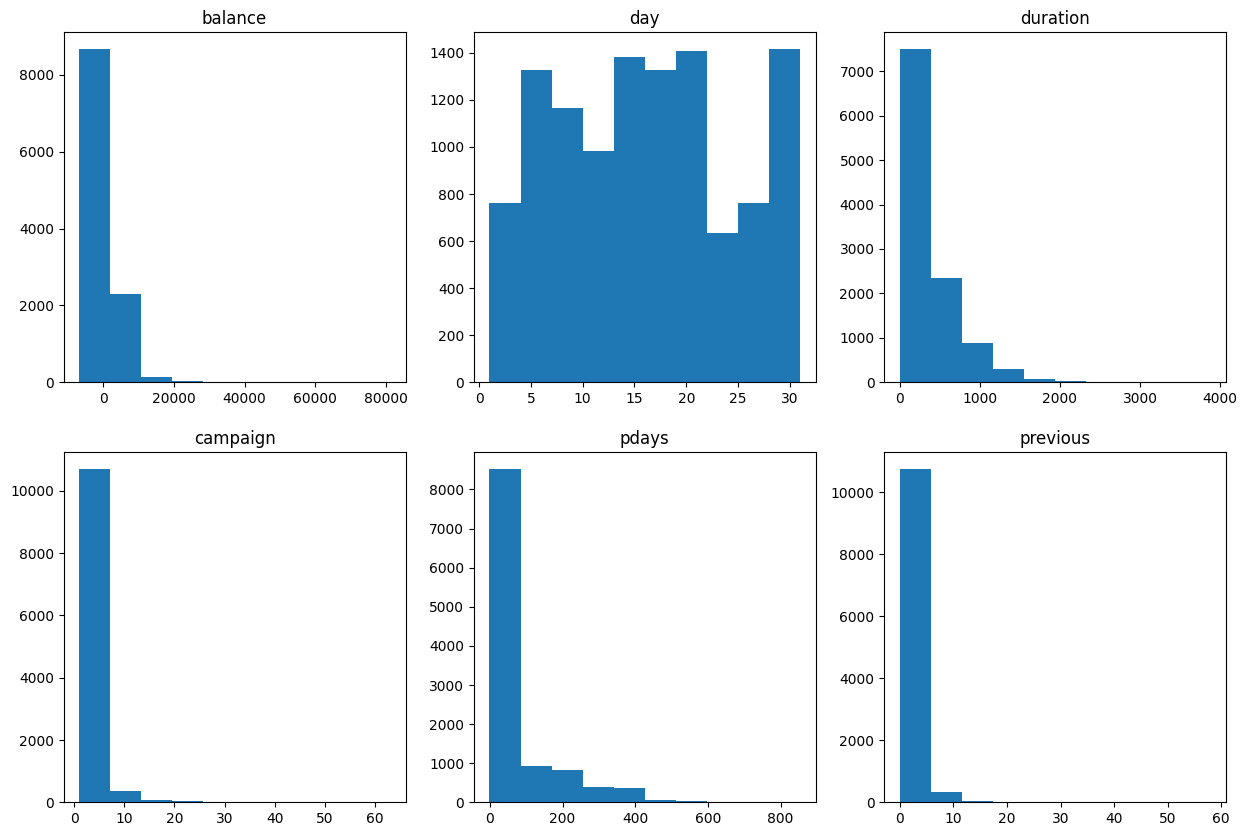

In [9]:
# List of numerical columns to be plotted
num_columns = ['balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for ax, num_column in zip(axs.flatten(), num_columns):
    # Create a histogram for the current numerical column
    ax.hist(df[num_column])
    ax.set_title(num_column)

# Display the plot
plt.show()


We can see that numerical columns have outliers (especially 'pdays', 'campaign' and 'previous' columns). Possibly there are incorrect values (noisy data), so we should look closer at the data and decide how do we manage the noise.
looking closer at the values of 'campaign', 'pdays' and 'previous' columns

In [10]:
# Display summary statistics for 'pdays', 'campaign', and 'previous' columns
summary_statistics = df[['pdays', 'campaign', 'previous']].describe()
print(summary_statistics)

# Calculate the percentage of 'pdays' values above 400
percentage_above_400 = (len(df[df['pdays'] > 400]) / len(df)) * 100
print(f"Percentage of 'pdays' values above 400: {percentage_above_400:.2f}%" )


              pdays      campaign      previous
count  11162.000000  11162.000000  11162.000000
mean      51.330407      2.508421      0.832557
std      108.758282      2.722077      2.292007
min       -1.000000      1.000000      0.000000
25%       -1.000000      1.000000      0.000000
50%       -1.000000      2.000000      0.000000
75%       20.750000      3.000000      1.000000
max      854.000000     63.000000     58.000000
Percentage of 'pdays' values above 400: 1.20%


'pdays' holds the number of days that passed by after the client was last contacted from a previous campaign Looking closer into 'pdays' data we can see that:

only 1.2% of values above 400. They are possibly outliers, so I consider consider imputing something (possibly mean value) instead of these values.
-1 possibly means that the client wasn't contacted before or stands for missing data.
Since I am not sure exactly what -1 means I decided to drop this column, because -1 makes more than 50% of the values of the column.

In [11]:
# Calculate the percentage of 'campaign' values above 20
percentage_above_20 = (len(df[df['campaign'] > 20]) / len(df)) * 100
print(f"Percentage of 'campaign' values above 20: {percentage_above_20:.2f}%")


Percentage of 'campaign' values above 20: 0.38%


'campaign' holds the number of contacts performed during this campaign and for this client (numeric, includes last contact) Numbers for 'campaign' above 34 are clearly noise, so I suggest to impute them with average campaign values while data cleaning.

In [12]:
# Calculate the percentage of 'previous' values above 20

len (df[df['previous'] > 34] ) / len(df) * 100

0.04479483963447411

'previous' holds the number of contacts performed before this campaign and for this client (numeric) Numbers for 'previous' above 34 are also really strange, so I imputeed them with average campaign values while data cleaning.

## Analysis of the response column

It is very important to look at the response column, which holds the information, which we are going to predict. In this case we should look at 'deposit' column and compare its values to other columns.
Firstly, looking at the number of 'yes' and 'no' values in the response column 'deposit'.

<Axes: title={'center': 'Deposit value counts'}>

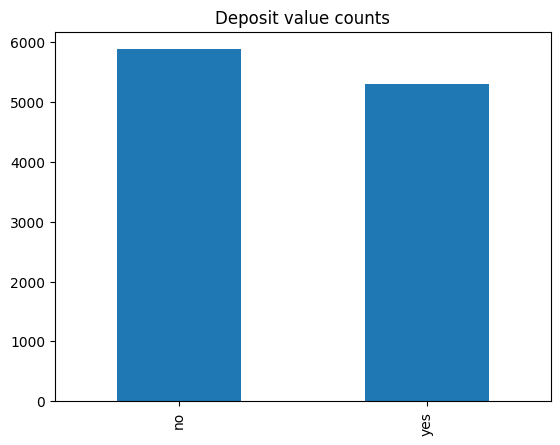

In [13]:
value_counts = df['deposit'].value_counts()
value_counts.plot.bar(title = 'Deposit value counts')

The counts for 'yes' and 'no' values for 'deposit' are close, so we can use accuracy as a metric for a model, which predicts the campaign outcome

Below we can see how 'deposit' column value varies depending on other categorical columns' values

<Axes: title={'center': 'Job and deposit'}>

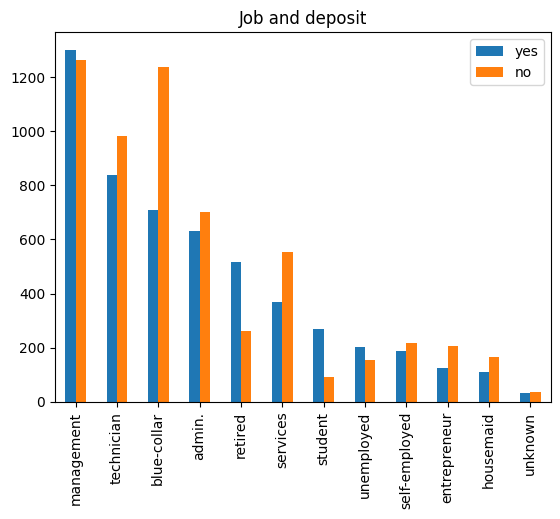

In [14]:
#job and deposit
j_df = pd.DataFrame()

j_df['yes'] = df[df['deposit'] == 'yes']['job'].value_counts()
j_df['no'] = df[df['deposit'] == 'no']['job'].value_counts()

j_df.plot.bar(title = 'Job and deposit')

<Axes: title={'center': 'Marital status and deposit'}>

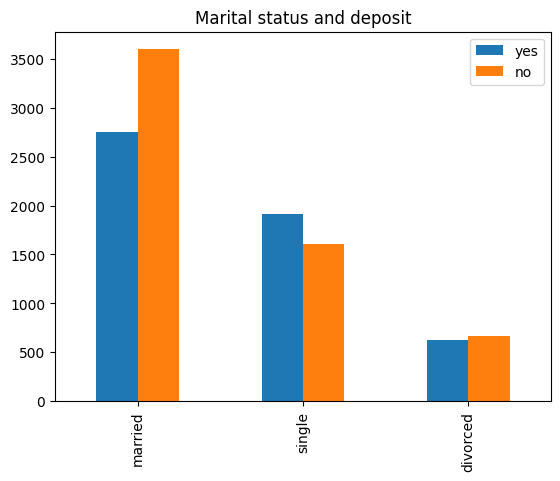

In [15]:
#marital status and deposit
j_df = pd.DataFrame()

j_df['yes'] = df[df['deposit'] == 'yes']['marital'].value_counts()
j_df['no'] = df[df['deposit'] == 'no']['marital'].value_counts()

j_df.plot.bar(title = 'Marital status and deposit')

<Axes: title={'center': 'Education and deposit'}>

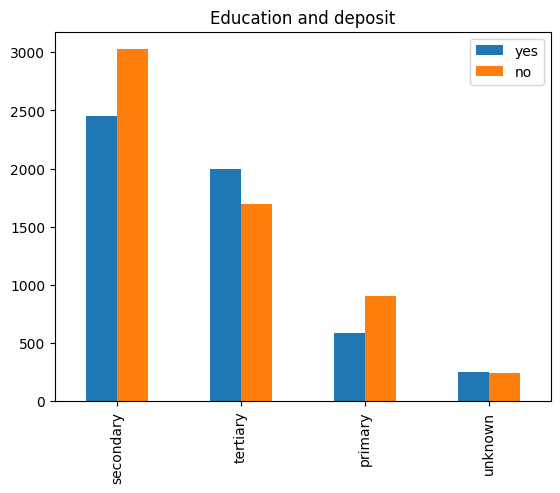

In [16]:
#education and deposit
j_df = pd.DataFrame()

j_df['yes'] = df[df['deposit'] == 'yes']['education'].value_counts()
j_df['no'] = df[df['deposit'] == 'no']['education'].value_counts()

j_df.plot.bar(title = 'Education and deposit')

<Axes: title={'center': 'Type of contact and deposit'}>

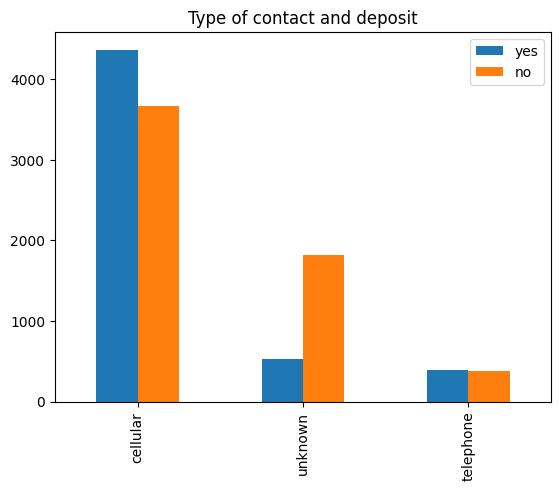

In [17]:
#type of contact and deposit
j_df = pd.DataFrame()

j_df['yes'] = df[df['deposit'] == 'yes']['contact'].value_counts()
j_df['no'] = df[df['deposit'] == 'no']['contact'].value_counts()

j_df.plot.bar(title = 'Type of contact and deposit')

We can tell that according to our dataset: from the above analysis

1. Customers with 'blue-collar' and 'services' jobs are less likely to subscribe for term deposit.
2. Married customers are less likely to subscribe for term deposit.
3. Customers with 'cellular' type of contact are less likely to subscribe for term deposit.

### Below :- Numerical columns affect term deposit subscription

In [18]:
#balance and deposit

b_df = pd.DataFrame()
b_df['balance_yes'] = (df[df['deposit'] == 'yes'][['deposit','balance']].describe())['balance']
b_df['balance_no'] = (df[df['deposit'] == 'no'][['deposit','balance']].describe())['balance']

b_df

,balance_yes,balance_no
count,5289.000000,5873.000000
mean,1804.267915,1280.227141
std,3501.104777,2933.411934
min,-3058.000000,-6847.000000
25%,210.000000,64.000000
50%,733.000000,414.000000
75%,2159.000000,1324.000000
max,81204.000000,66653.000000


<Axes: title={'center': 'Balance and deposit statistics'}>

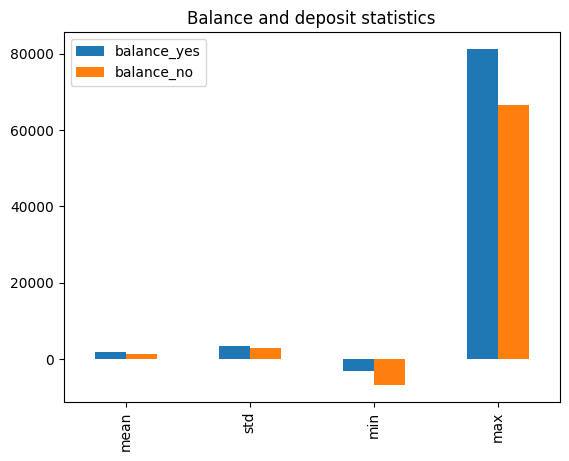

In [19]:
b_df.drop(['count', '25%', '50%', '75%']).plot.bar(title = 'Balance and deposit statistics')

In [20]:
#age and deposit

a_df = pd.DataFrame()
a_df['age_yes'] = (df[df['deposit'] == 'yes'][['deposit','age']].describe())['age']
a_df['age_no'] = (df[df['deposit'] == 'no'][['deposit','age']].describe())['age']

a_df

,age_yes,age_no
count,5289.000000,5873.000000
mean,41.670070,40.837391
std,13.497781,10.264815
min,18.000000,18.000000
25%,31.000000,33.000000
50%,38.000000,39.000000
75%,50.000000,48.000000
max,95.000000,89.000000


<Axes: title={'center': 'Age and deposit statistics'}>

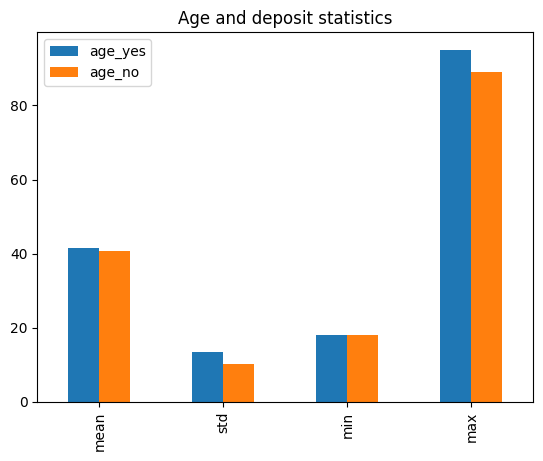

In [21]:
a_df.drop(['count', '25%', '50%', '75%']).plot.bar(title = 'Age and deposit statistics')

In [22]:
#number of contacts performed during this campaign ('campaign') and deposit
c_df = pd.DataFrame()
c_df['campaign_yes'] = (df[df['deposit'] == 'yes'][['deposit','campaign']].describe())['campaign']
c_df['campaign_no'] = (df[df['deposit'] == 'no'][['deposit','campaign']].describe())['campaign']

c_df

,campaign_yes,campaign_no
count,5289.000000,5873.000000
mean,2.141047,2.839264
std,1.921826,3.244474
min,1.000000,1.000000
25%,1.000000,1.000000
50%,2.000000,2.000000
75%,3.000000,3.000000
max,32.000000,63.000000


<Axes: title={'center': 'Number of contacts performed during this campaign and deposit statistics'}>

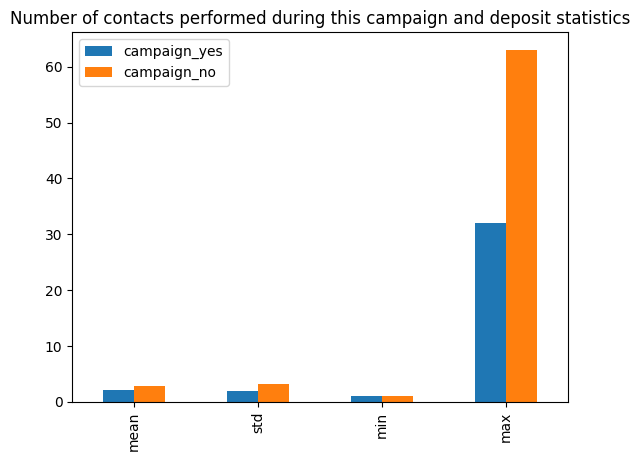

In [23]:
c_df.drop(['count', '25%', '50%', '75%']).plot.bar(title = 'Number of contacts performed during this campaign and deposit statistics')

In [24]:
#number of contacts performed during previous campaign ('previous') and deposit
p_df = pd.DataFrame()
p_df['previous_yes'] = (df[df['deposit'] == 'yes'][['deposit','previous']].describe())['previous']
p_df['previous_no'] = (df[df['deposit'] == 'no'][['deposit','previous']].describe())['previous']

p_df

,previous_yes,previous_no
count,5289.000000,5873.00000
mean,1.170354,0.52835
std,2.553272,1.97961
min,0.000000,0.00000
25%,0.000000,0.00000
50%,0.000000,0.00000
75%,1.000000,0.00000
max,58.000000,41.00000


<Axes: title={'center': 'Number of contacts performed during previous campaign and deposit statistics'}>

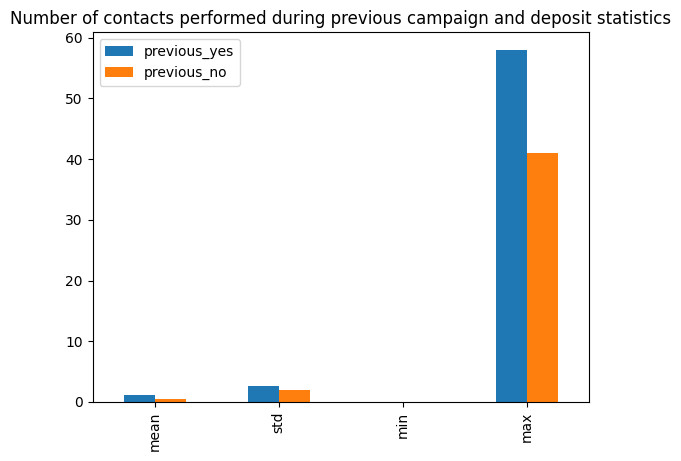

In [25]:
p_df.drop(['count', '25%', '50%', '75%']).plot.bar(title = 'Number of contacts performed during previous campaign and deposit statistics')

we can conclude that:

1. People who subscribed for term deposit tend to have greater balance and age values.
2. People who subscribed for term deposit tend to have fewer number of contacts during this campaign.

## Data Cleaning

Before we will be able to apply machine learning techniques, we should prepare the dataset for processing:

1. Convert columns with 'yes' and 'no' values to boolean columns
2. Convert categorical columns into dummy variables.

In [26]:
def get_dummy_from_bool(row, column_name):
    '''Returns 0 if value in column_name is no, returns 1 if value in column_name is yes'''
    return 1 if row[column_name] == 'yes' else 0

def get_correct_values(row, column_name, threshold, df):
    '''Returns mean value if value in column_name is above threshold'''
    if row[column_name] <= threshold:
        return row[column_name]
    else:
        mean = df[df[column_name] <= threshold][column_name].mean()
        return mean

def clean_data(df):

    # Create a copy of the original DataFrame
    cleaned_df = df.copy()

    # Convert columns containing 'yes' and 'no' values to boolean variables and drop original columns
    bool_columns = ['default', 'housing', 'loan', 'deposit']
    for bool_col in bool_columns:
        cleaned_df[bool_col + '_bool'] = df.apply(lambda row: get_dummy_from_bool(row, bool_col), axis=1)

    cleaned_df = cleaned_df.drop(columns=bool_columns)

    # Convert categorical columns to dummy variables
    cat_columns = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']
    for col in cat_columns:
        cleaned_df = pd.concat([cleaned_df.drop(col, axis=1),
                                pd.get_dummies(cleaned_df[col], prefix=col, prefix_sep='_',
                                               drop_first=True, dummy_na=False)], axis=1)

    # Drop irrelevant columns
    cleaned_df = cleaned_df.drop(columns=['pdays'])

    # Impute incorrect values and drop original columns
    cleaned_df['campaign_cleaned'] = df.apply(lambda row: get_correct_values(row, 'campaign', 34, cleaned_df), axis=1)
    cleaned_df['previous_cleaned'] = df.apply(lambda row: get_correct_values(row, 'previous', 34, cleaned_df), axis=1)

    cleaned_df = cleaned_df.drop(columns=['campaign', 'previous'])

    return cleaned_df


In [27]:
#clean the dataset
cleaned_df = clean_data(df)
cleaned_df.head()

,age,balance,day,duration,default_bool,housing_bool,loan_bool,deposit_bool,job_blue-collar,job_entrepreneur,...,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown,campaign_cleaned,previous_cleaned
0,59,2343,5,1042,0,1,0,1,0,0,...,0,1,0,0,0,0,0,1,1.0,0.0
1,56,45,5,1467,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,1.0,0.0
2,41,1270,5,1389,0,1,0,1,0,0,...,0,1,0,0,0,0,0,1,1.0,0.0
3,55,2476,5,579,0,1,0,1,0,0,...,0,1,0,0,0,0,0,1,1.0,0.0
4,54,184,5,673,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,2.0,0.0


# Classification model for the campaign outcome prediction : XGBoost

Now we will use cleaned dataset for prediction of campaign outcome with help of machine learning classification models. I will use XGBoost, which is one of the most common machine learning libraries for modelling.

Resulting model will also help me to understand, which features have the
greatest importance for the prediction of the results of the campaing.

In [28]:
# Create X and y datasets for training the model and split into train and test datasets.

X = cleaned_df.drop(columns = 'deposit_bool')
y = cleaned_df[['deposit_bool']]
TEST_SIZE = 0.3
RAND_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE, random_state=RAND_STATE)

In [29]:
# Train XGBoost classifier model

xgb = xgboost.XGBClassifier(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
xgb.fit(X_train,y_train.squeeze().values)

#calculate and print scores for the model for top 15 features
y_train_preds = xgb.predict(X_train)
y_test_preds = xgb.predict(X_test)

print('XGB accuracy score for train: %.3f: test: %.3f' % (
        accuracy_score(y_train, y_train_preds),
        accuracy_score(y_test, y_test_preds)))

XGB accuracy score for train: 0.914: test: 0.850


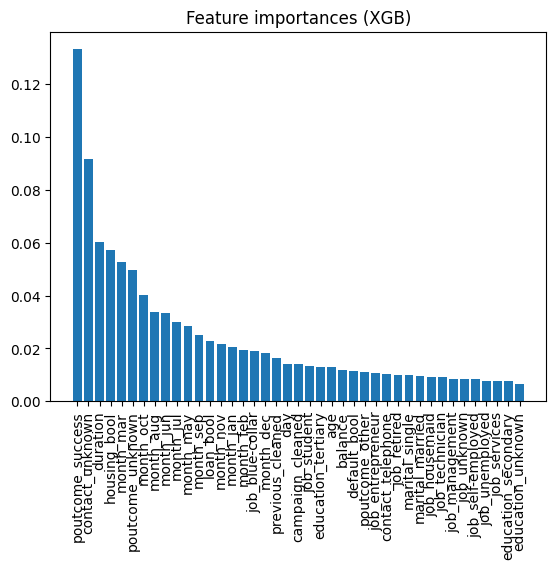

In [30]:
#get feature importances from the model

headers = ["name", "score"]
values = sorted(zip(X_train.columns, xgb.feature_importances_), key=lambda x: x[1] * -1)
xgb_feature_importances = pd.DataFrame(values, columns = headers)

#plot feature importances
x_pos = np.arange(0, len(xgb_feature_importances))
plt.bar(x_pos, xgb_feature_importances['score'])
plt.xticks(x_pos, xgb_feature_importances['name'])
plt.xticks(rotation=90)
plt.title('Feature importances (XGB)')

plt.show()

As we can see from the diagram showing feature importances, the most important features are:

1. Customer's account balance,
2. Customer's age,
3. Number of contacts performed during this campaign and contact duration,
4. Number of contacts performed before this campaign.

So the main outcomes of the modelling are:

1. Customers of greater age are more likely to subscribe for the term deposit.
2. Customers with greater account balance are more likely to subscribe for the term deposit.
3. Number of contacts with the customers really matters. Too many contacts with the customer could make him decline the offer.

## More specific recommendations

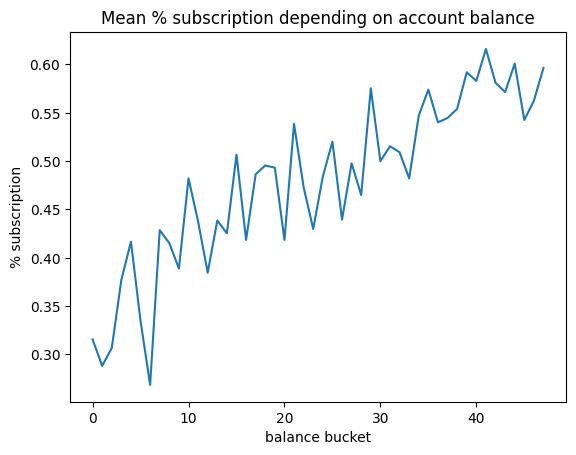

1490

In [31]:
# Finding out account balance, which marketing campaign should focus on

df_new = cleaned_df.copy()

#introduce new column 'balance_buckets' to  ''
df_new['balance_buckets'] = pd.qcut(df_new['balance'], 50, labels=False, duplicates = 'drop')

#group by 'balance_buckets' and find average campaign outcome per balance bucket
mean_deposit = df_new.groupby(['balance_buckets'])['deposit_bool'].mean()

#plot
plt.plot(mean_deposit.index, mean_deposit.values)
plt.title('Mean % subscription depending on account balance')
plt.xlabel('balance bucket')
plt.ylabel('% subscription')
plt.show()

df_new[df_new['balance_buckets'] == 34]['balance'].min()

From the diagram above we can conclude, that marketing campaigns should concentrate on customers with account balance greater than 1490$.

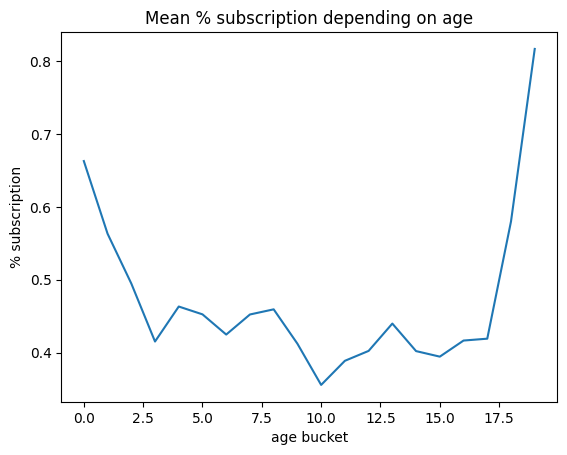

In [32]:
#introduce new column 'age_buckets' to  ''

df_new['age_buckets'] = pd.qcut(df_new['age'], 20, labels=False, duplicates = 'drop')

#group by 'balance_buckets' and find average campaign outcome per balance bucket
mean_age = df_new.groupby(['age_buckets'])['deposit_bool'].mean()

#plot
plt.plot(mean_age.index, mean_age.values)
plt.title('Mean % subscription depending on age')
plt.xlabel('age bucket')
plt.ylabel('% subscription')
plt.show()

In [33]:
# Find theaverage age for the group with 'age_buckets' equal to 3
max_age_for_bucket_3 = df_new[df_new['age_buckets'] == 3]['age'].max()
print(f"The maximum age for the group is: {max_age_for_bucket_3}")

# Find the minimum age for the group with 'age_buckets' equal to 17
min_age_for_bucket_17 = df_new[df_new['age_buckets'] == 17]['age'].min()
print(f"The minimum age for the group is: {min_age_for_bucket_17}")


The maximum age for the group is: 31
The minimum age for the group is: 56


 Average subscrition rate tends to be higher for customers below 31 years old or above 56 years old.

## Find out appropriate number of contacts with the customer during campaign

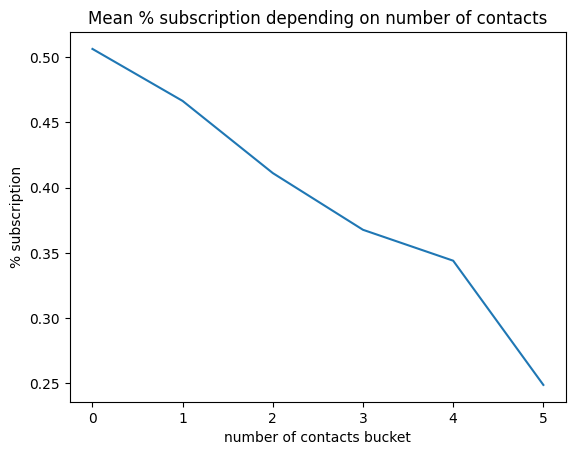

In [34]:
#introduce new column 'age_buckets' to  ''
df_new['campaign_buckets'] = pd.qcut(df_new['campaign_cleaned'], 20, labels=False, duplicates = 'drop')

#group by 'balance_buckets' and find average campaign outcome per balance bucket
mean_campaign = df_new.groupby(['campaign_buckets'])['deposit_bool'].mean()

#plot average campaign outcome per bucket
plt.plot(mean_campaign.index, mean_campaign.values)
plt.title('Mean % subscription depending on number of contacts')
plt.xlabel('number of contacts bucket')
plt.ylabel('% subscription')
plt.show()

In [35]:
# Find the minimum 'campaign_cleaned' value for the group with 'campaign_buckets' equal to 2
min_campaign_cleaned_for_bucket_2 = df_new[df_new['campaign_buckets'] == 2]['campaign_cleaned'].min()
print(f"The minimum 'campaign_cleaned' value for the group with 'campaign_buckets' equal to 2 is: {min_campaign_cleaned_for_bucket_2}")


The minimum 'campaign_cleaned' value for the group with 'campaign_buckets' equal to 2 is: 4.0


From the plot above we see that average subscription rate is below 50% if the number of contacts during the campaign exceeds 4.

# Conclusion

From all the analysis, Recommendations for future marketing campaigns

1. **Account Balance Influence:**
   - "Customers with more than $1490 in their account are more likely to subscribe to a term deposit. Focus on reaching out to these customers in future campaigns."

2. **Age Influence:**
   - "The age of the customer matters for campaign success. Concentrate on customers below 30 and above 50 years old in future campaigns."

3. **Number of Contacts:**
   - "Limit the number of contacts with a customer during the campaign to 4 or fewer, as it significantly impacts the campaign outcome."